# Import Libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from pdb import set_trace as bp
import pandas as pd

# Transformations

In [0]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       #transforms.RandomAffine((-5.0,5.0),fillcolor=1),
                                       #transforms.RandomPerspective(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Load dataset

In [0]:
train = datasets.MNIST('./data', train=True, download=True,transform=train_transforms)
test = datasets.MNIST('./data', train=True, download=True,transform=test_transforms)

# Dataloaders: Test/Train dataset

In [42]:
SEED = 3

# is cuda available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4,pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, ** dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Basic Model

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 26 output_size = 24 receptive_field = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 24 output_size = 22 receptive_field = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 22 output_size = 11 receptive_field = 9
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 11 output_size = 11 receptive_field = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 11 output_size = 9 receptive_field = 13
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 9 output_size = 7 receptive_field = 17
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 7 output_size = 5 receptive_field = 21
        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
        ) # input_size = 5 output_size = 1  receptive_field = 29
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [44]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1

#Training & Testing

In [0]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, l1_reg=False, l1_lambda=0):
  #bp()
  train_epoch_acc = []
  train_epoch_loss = []
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if l1_reg:
       
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0
        for param in model.parameters():
            zero_tensor = torch.zeros(param.size()).to(device)
            #bp()
            reg_loss += l1_crit(param, zero_tensor)

        
        loss += l1_lambda * reg_loss

    # Backpropagation
    loss.backward()
    train_epoch_loss.append(loss.item())
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_epoch_acc.append(100*correct/processed)

  return train_epoch_acc, train_epoch_loss

def test(model, device, test_loader, 
         return_misclassified=False, 
         number_of_images_to_return=0, 
         return_worst_predictions=False):

    misclassified_images_list = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_value = torch.max(output, dim=1).values

            
            match_tensor = pred.eq(target.view_as(pred))
            misclassified_images_in_batch = torch.where(match_tensor == False)
            for eachimage in misclassified_images_in_batch[0]:
               #bp()
               image_predlist = [data[eachimage], pred[eachimage].item(), pred_value[eachimage].item(), target[eachimage].item()]
               misclassified_images_list.append(image_predlist)
            correct += match_tensor.sum().item()

    test_loss /= len(test_loader.dataset)
    

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc = 100. * correct / len(test_loader.dataset)
    #bp()
    if return_misclassified:
      if not return_worst_predictions:
        return test_acc, test_loss, misclassified_images_list[:number_of_images_to_return]
      else:
        sorted_on_pred_value = sorted(misclassified_images_list, key = lambda x: x[2], reverse=True)
        return test_acc, test_loss, sorted_on_pred_value[:number_of_images_to_return]
    
    return test_acc, test_loss

# Train & Test model

In [46]:
train_acc_no_reg = []
train_losses_no_reg = []
test_acc_no_reg = []
test_losses_no_reg = []
model_no_reg =  Net().to(device)
optimizer = optim.SGD(model_no_reg.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_no_reg, train_epoch_losses_no_reg = train(model_no_reg, device, train_loader, optimizer, epoch)
    train_acc_no_reg.extend(train_epoch_acc_no_reg)
    train_losses_no_reg.extend(train_epoch_losses_no_reg)

    test_acc_no_reg_epoch, test_losses_no_reg_epoch = test(model_no_reg, device, test_loader)
    test_acc_no_reg.append(test_acc_no_reg_epoch)
    test_losses_no_reg.append(test_losses_no_reg_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07194755226373672 Batch_id=468 Accuracy=93.12: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0696, Accuracy: 58711/60000 (97.85%)

EPOCH: 1


Loss=0.05205740034580231 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:13<00:00, 43.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 59045/60000 (98.41%)

EPOCH: 2


Loss=0.04005415365099907 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 34.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 59213/60000 (98.69%)

EPOCH: 3


Loss=0.09029648452997208 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 44.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 59211/60000 (98.69%)

EPOCH: 4


Loss=0.01605670154094696 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 59364/60000 (98.94%)

EPOCH: 5


Loss=0.04322938248515129 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 59409/60000 (99.02%)

EPOCH: 6


Loss=0.04966530203819275 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:12<00:00, 36.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 59483/60000 (99.14%)

EPOCH: 7


Loss=0.09964699298143387 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 59465/60000 (99.11%)

EPOCH: 8


Loss=0.047841671854257584 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 42.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 59458/60000 (99.10%)

EPOCH: 9


Loss=0.008282582275569439 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 39.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 59542/60000 (99.24%)

EPOCH: 10


Loss=0.1718917340040207 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:12<00:00, 36.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 59578/60000 (99.30%)

EPOCH: 11


Loss=0.12140101194381714 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 59481/60000 (99.14%)

EPOCH: 12


Loss=0.08891402930021286 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 42.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 59589/60000 (99.31%)

EPOCH: 13


Loss=0.02987327240407467 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 35.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 59618/60000 (99.36%)

EPOCH: 14


Loss=0.040201593190431595 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 59630/60000 (99.38%)

EPOCH: 15


Loss=0.03859643638134003 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 59585/60000 (99.31%)

EPOCH: 16


Loss=0.018603920936584473 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 59639/60000 (99.40%)

EPOCH: 17


Loss=0.1721401959657669 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:12<00:00, 36.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 59692/60000 (99.49%)

EPOCH: 18


Loss=0.029757842421531677 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 59639/60000 (99.40%)

EPOCH: 19


Loss=0.06917793303728104 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 59639/60000 (99.40%)

EPOCH: 20


Loss=0.033264417201280594 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 59690/60000 (99.48%)

EPOCH: 21


Loss=0.06641026586294174 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 59701/60000 (99.50%)

EPOCH: 22


Loss=0.043539296835660934 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 59653/60000 (99.42%)

EPOCH: 23


Loss=0.00432288134470582 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 59702/60000 (99.50%)

EPOCH: 24


Loss=0.007852067239582539 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 35.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 59699/60000 (99.50%)

EPOCH: 25


Loss=0.022877564653754234 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 59706/60000 (99.51%)

EPOCH: 26


Loss=0.024133801460266113 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 38.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 59718/60000 (99.53%)

EPOCH: 27


Loss=0.020671039819717407 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 59743/60000 (99.57%)

EPOCH: 28


Loss=0.009714419953525066 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 59770/60000 (99.62%)

EPOCH: 29


Loss=0.03468241170048714 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 59729/60000 (99.55%)

EPOCH: 30


Loss=0.003184209344908595 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 59745/60000 (99.58%)

EPOCH: 31


Loss=0.06554528325796127 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 38.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 59756/60000 (99.59%)

EPOCH: 32


Loss=0.0009276370401494205 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 34.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 59792/60000 (99.65%)

EPOCH: 33


Loss=0.03200636804103851 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 59761/60000 (99.60%)

EPOCH: 34


Loss=0.0039713033474981785 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 59775/60000 (99.62%)

EPOCH: 35


Loss=0.0007351438398472965 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 36.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 59776/60000 (99.63%)

EPOCH: 36


Loss=0.04020415619015694 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 59787/60000 (99.64%)

EPOCH: 37


Loss=0.00725517189130187 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 59767/60000 (99.61%)

EPOCH: 38


Loss=0.014654740691184998 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 59757/60000 (99.59%)

EPOCH: 39


Loss=0.0485190711915493 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]



Test set: Average loss: 0.0118, Accuracy: 59784/60000 (99.64%)



In [47]:
train_acc_l1 = []
train_losses_l1 = []
test_acc_l1 = []
test_losses_l1 = []

model_l1 =  Net().to(device)
optimizer = optim.SGD(model_l1.parameters(), lr=0.01, momentum=0.9)
misclassified_dict_args = dict(return_misclassified = True, 
                          number_of_images_to_return=25,
                          return_worst_predictions=True)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_l1, train_epoch_losses_l1 = train(model_l1, device, train_loader, optimizer, epoch, l1_reg=True, l1_lambda=0.0005)
    train_acc_l1.extend(train_epoch_acc_l1)
    train_losses_l1.extend(train_epoch_losses_l1)

    if epoch == EPOCHS-1:
        test_acc_l1_epoch, test_losses_l1_epoch, misclassified_list_l1 = test(model_l1, device, test_loader, ** misclassified_dict_args)
    else:    
        test_acc_l1_epoch, test_losses_l1_epoch = test(model_l1, device, test_loader)

    test_acc_l1.append(test_acc_l1_epoch)
    test_losses_l1.append(test_losses_l1_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.32034406065940857 Batch_id=468 Accuracy=92.43: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0793, Accuracy: 58624/60000 (97.71%)

EPOCH: 1


Loss=0.24680233001708984 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 59007/60000 (98.34%)

EPOCH: 2


Loss=0.210063636302948 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 58804/60000 (98.01%)

EPOCH: 3


Loss=0.2075696885585785 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 59158/60000 (98.60%)

EPOCH: 4


Loss=0.2838398814201355 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0688, Accuracy: 58722/60000 (97.87%)

EPOCH: 5


Loss=0.19615332782268524 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0587, Accuracy: 58889/60000 (98.15%)

EPOCH: 6


Loss=0.2426503300666809 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 59256/60000 (98.76%)

EPOCH: 7


Loss=0.2633903920650482 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0718, Accuracy: 58694/60000 (97.82%)

EPOCH: 8


Loss=0.16816304624080658 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 59161/60000 (98.60%)

EPOCH: 9


Loss=0.2236124575138092 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 59184/60000 (98.64%)

EPOCH: 10


Loss=0.1792142540216446 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 59065/60000 (98.44%)

EPOCH: 11


Loss=0.22102238237857819 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 59174/60000 (98.62%)

EPOCH: 12


Loss=0.19563719630241394 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 31.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 59321/60000 (98.87%)

EPOCH: 13


Loss=0.1583404690027237 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 38.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 59057/60000 (98.43%)

EPOCH: 14


Loss=0.24176695942878723 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 59117/60000 (98.53%)

EPOCH: 15


Loss=0.21192234754562378 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 30.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 59179/60000 (98.63%)

EPOCH: 16


Loss=0.24952568113803864 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 59311/60000 (98.85%)

EPOCH: 17


Loss=0.2075181007385254 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 59222/60000 (98.70%)

EPOCH: 18


Loss=0.13486447930335999 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 59175/60000 (98.62%)

EPOCH: 19


Loss=0.15993428230285645 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 59306/60000 (98.84%)

EPOCH: 20


Loss=0.1600961834192276 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 59264/60000 (98.77%)

EPOCH: 21


Loss=0.20636844635009766 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 59225/60000 (98.71%)

EPOCH: 22


Loss=0.18679311871528625 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 31.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 59158/60000 (98.60%)

EPOCH: 23


Loss=0.1441180258989334 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 39.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 59236/60000 (98.73%)

EPOCH: 24


Loss=0.21077263355255127 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 36.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 59368/60000 (98.95%)

EPOCH: 25


Loss=0.13994818925857544 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 34.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 59203/60000 (98.67%)

EPOCH: 26


Loss=0.1565958559513092 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 59277/60000 (98.80%)

EPOCH: 27


Loss=0.18768800795078278 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 59152/60000 (98.59%)

EPOCH: 28


Loss=0.20303358137607574 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 59116/60000 (98.53%)

EPOCH: 29


Loss=0.1640225201845169 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 59349/60000 (98.92%)

EPOCH: 30


Loss=0.1421496421098709 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 37.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 59194/60000 (98.66%)

EPOCH: 31


Loss=0.15541262924671173 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 59160/60000 (98.60%)

EPOCH: 32


Loss=0.1686801314353943 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 59321/60000 (98.87%)

EPOCH: 33


Loss=0.14281561970710754 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 59241/60000 (98.73%)

EPOCH: 34


Loss=0.11432985216379166 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 30.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 59286/60000 (98.81%)

EPOCH: 35


Loss=0.1436418890953064 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 59163/60000 (98.61%)

EPOCH: 36


Loss=0.1424976885318756 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 31.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 59266/60000 (98.78%)

EPOCH: 37


Loss=0.17425522208213806 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 59201/60000 (98.67%)

EPOCH: 38


Loss=0.1758478730916977 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 59295/60000 (98.83%)

EPOCH: 39


Loss=0.16718409955501556 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]



Test set: Average loss: 0.0420, Accuracy: 59192/60000 (98.65%)



In [77]:
train_acc_l2 = []
train_losses_l2 = []
test_acc_l2 = []
test_losses_l2 = []

model_l2 =  Net().to(device)
optimizer = optim.SGD(model_l2.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
misclassified_dict_args = dict(return_misclassified = True, 
                          number_of_images_to_return=25,
                          return_worst_predictions=True)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_l2, train_epoch_losses_l2 = train(model_l2, device, train_loader, optimizer, epoch)
    train_acc_l2.extend(train_epoch_acc_l2)
    train_losses_l2.extend(train_epoch_losses_l2)

    if epoch == EPOCHS-1:
        test_acc_l2_epoch, test_losses_l2_epoch, misclassified_list_l2 = test(model_l2, device, test_loader, ** misclassified_dict_args)
    else:    
        test_acc_l2_epoch, test_losses_l2_epoch = test(model_l2, device, test_loader)

    test_acc_l2.append(test_acc_l2_epoch)
    test_losses_l2.append(test_losses_l2_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.12907204031944275 Batch_id=468 Accuracy=92.87: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0696, Accuracy: 58696/60000 (97.83%)

EPOCH: 1


Loss=0.04645406827330589 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:13<00:00, 40.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 59076/60000 (98.46%)

EPOCH: 2


Loss=0.07517164200544357 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 59283/60000 (98.81%)

EPOCH: 3


Loss=0.045777902007102966 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 59337/60000 (98.89%)

EPOCH: 4


Loss=0.03143149986863136 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 59442/60000 (99.07%)

EPOCH: 5


Loss=0.04649971425533295 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 59426/60000 (99.04%)

EPOCH: 6


Loss=0.05668165907263756 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 37.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 59535/60000 (99.22%)

EPOCH: 7


Loss=0.03227303549647331 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 59544/60000 (99.24%)

EPOCH: 8


Loss=0.01653199829161167 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 59599/60000 (99.33%)

EPOCH: 9


Loss=0.039974842220544815 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 59566/60000 (99.28%)

EPOCH: 10


Loss=0.036305591464042664 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 59589/60000 (99.31%)

EPOCH: 11


Loss=0.02273121476173401 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 59565/60000 (99.28%)

EPOCH: 12


Loss=0.04586467146873474 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 59602/60000 (99.34%)

EPOCH: 13


Loss=0.014483491890132427 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 41.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 59638/60000 (99.40%)

EPOCH: 14


Loss=0.04522518813610077 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 59651/60000 (99.42%)

EPOCH: 15


Loss=0.04820966348052025 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 41.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 59680/60000 (99.47%)

EPOCH: 16


Loss=0.060661330819129944 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 59614/60000 (99.36%)

EPOCH: 17


Loss=0.048262689262628555 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 59643/60000 (99.41%)

EPOCH: 18


Loss=0.01000987458974123 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 59653/60000 (99.42%)

EPOCH: 19


Loss=0.01082716416567564 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 34.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 59678/60000 (99.46%)

EPOCH: 20


Loss=0.06065597012639046 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 59655/60000 (99.42%)

EPOCH: 21


Loss=0.06290803104639053 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 59594/60000 (99.32%)

EPOCH: 22


Loss=0.04305398836731911 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 59632/60000 (99.39%)

EPOCH: 23


Loss=0.08725950121879578 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 59720/60000 (99.53%)

EPOCH: 24


Loss=0.004607548471540213 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 59647/60000 (99.41%)

EPOCH: 25


Loss=0.04257168993353844 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 59685/60000 (99.47%)

EPOCH: 26


Loss=0.04400092363357544 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 59707/60000 (99.51%)

EPOCH: 27


Loss=0.02017500065267086 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 59695/60000 (99.49%)

EPOCH: 28


Loss=0.015609134919941425 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 59718/60000 (99.53%)

EPOCH: 29


Loss=0.04166211560368538 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 59708/60000 (99.51%)

EPOCH: 30


Loss=0.05048925802111626 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 59702/60000 (99.50%)

EPOCH: 31


Loss=0.020758822560310364 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 59688/60000 (99.48%)

EPOCH: 32


Loss=0.023009397089481354 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:15<00:00, 36.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 59720/60000 (99.53%)

EPOCH: 33


Loss=0.0026028454303741455 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 59717/60000 (99.53%)

EPOCH: 34


Loss=0.039580490440130234 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 59713/60000 (99.52%)

EPOCH: 35


Loss=0.01397240161895752 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 39.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 59707/60000 (99.51%)

EPOCH: 36


Loss=0.010159055702388287 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 43.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 59728/60000 (99.55%)

EPOCH: 37


Loss=0.009466712363064289 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 59722/60000 (99.54%)

EPOCH: 38


Loss=0.007452085614204407 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 59718/60000 (99.53%)

EPOCH: 39


Loss=0.03884558752179146 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]



Test set: Average loss: 0.0144, Accuracy: 59746/60000 (99.58%)



In [49]:
train_acc_l1_l2 = []
train_losses_l1_l2 = []
test_acc_l1_l2 = []
test_losses_l1_l2 = []

model_l1_l2 =  Net().to(device)
optimizer = optim.SGD(model_l1_l2.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_l1_l2, train_epoch_losses_l1_l2 = train(model_l1_l2, device, train_loader, optimizer, epoch, l1_reg=True, l1_lambda=0.0005)
    train_acc_l1_l2.extend(train_epoch_acc_l1_l2)
    train_losses_l1_l2.extend(train_epoch_losses_l1_l2)

    test_acc_l1_l2_epoch, test_losses_l1_l2_epoch = test(model_l1_l2, device, test_loader)
    test_acc_l1_l2.append(test_acc_l1_l2_epoch)
    test_losses_l1_l2.append(test_losses_l1_l2_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.36265307664871216 Batch_id=468 Accuracy=93.00: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1091, Accuracy: 58007/60000 (96.68%)

EPOCH: 1


Loss=0.21379853785037994 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0622, Accuracy: 58841/60000 (98.07%)

EPOCH: 2


Loss=0.24198812246322632 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:15<00:00, 38.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 58851/60000 (98.08%)

EPOCH: 3


Loss=0.1944773942232132 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0719, Accuracy: 58677/60000 (97.80%)

EPOCH: 4


Loss=0.17524001002311707 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:14<00:00, 31.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 59222/60000 (98.70%)

EPOCH: 5


Loss=0.22989428043365479 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:14<00:00, 38.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 59059/60000 (98.43%)

EPOCH: 6


Loss=0.21353894472122192 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 59101/60000 (98.50%)

EPOCH: 7


Loss=0.15785180032253265 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 59124/60000 (98.54%)

EPOCH: 8


Loss=0.15508945286273956 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:15<00:00, 37.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 59214/60000 (98.69%)

EPOCH: 9


Loss=0.1640445441007614 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 59255/60000 (98.76%)

EPOCH: 10


Loss=0.26594340801239014 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:15<00:00, 40.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 59303/60000 (98.84%)

EPOCH: 11


Loss=0.18022972345352173 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 39.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 59012/60000 (98.35%)

EPOCH: 12


Loss=0.16429206728935242 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:15<00:00, 36.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 59240/60000 (98.73%)

EPOCH: 13


Loss=0.20221459865570068 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 59215/60000 (98.69%)

EPOCH: 14


Loss=0.15568485856056213 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 32.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 59142/60000 (98.57%)

EPOCH: 15


Loss=0.17994807660579681 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 59211/60000 (98.69%)

EPOCH: 16


Loss=0.19565430283546448 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 39.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 59048/60000 (98.41%)

EPOCH: 17


Loss=0.2244565784931183 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 59067/60000 (98.44%)

EPOCH: 18


Loss=0.16397473216056824 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 59211/60000 (98.69%)

EPOCH: 19


Loss=0.204928919672966 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 59100/60000 (98.50%)

EPOCH: 20


Loss=0.14126235246658325 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 29.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 59259/60000 (98.77%)

EPOCH: 21


Loss=0.17409422993659973 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0627, Accuracy: 58836/60000 (98.06%)

EPOCH: 22


Loss=0.20831245183944702 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 59196/60000 (98.66%)

EPOCH: 23


Loss=0.15855461359024048 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 59352/60000 (98.92%)

EPOCH: 24


Loss=0.1842464804649353 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 59275/60000 (98.79%)

EPOCH: 25


Loss=0.12513642013072968 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 59145/60000 (98.58%)

EPOCH: 26


Loss=0.20072884857654572 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 59117/60000 (98.53%)

EPOCH: 27


Loss=0.17780938744544983 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 34.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0833, Accuracy: 58518/60000 (97.53%)

EPOCH: 28


Loss=0.1615985780954361 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 59264/60000 (98.77%)

EPOCH: 29


Loss=0.12155795097351074 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 59205/60000 (98.67%)

EPOCH: 30


Loss=0.17422378063201904 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 59032/60000 (98.39%)

EPOCH: 31


Loss=0.13661496341228485 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 59168/60000 (98.61%)

EPOCH: 32


Loss=0.1763417273759842 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 59054/60000 (98.42%)

EPOCH: 33


Loss=0.18359819054603577 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 59100/60000 (98.50%)

EPOCH: 34


Loss=0.16211864352226257 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 59131/60000 (98.55%)

EPOCH: 35


Loss=0.15564490854740143 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0619, Accuracy: 58862/60000 (98.10%)

EPOCH: 36


Loss=0.27945730090141296 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 59096/60000 (98.49%)

EPOCH: 37


Loss=0.19837915897369385 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 59200/60000 (98.67%)

EPOCH: 38


Loss=0.12471115589141846 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 59081/60000 (98.47%)

EPOCH: 39


Loss=0.1516495943069458 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 37.34it/s]



Test set: Average loss: 0.0715, Accuracy: 58660/60000 (97.77%)



Text(0.5, 1.0, 'Test Loss vs Epochs')

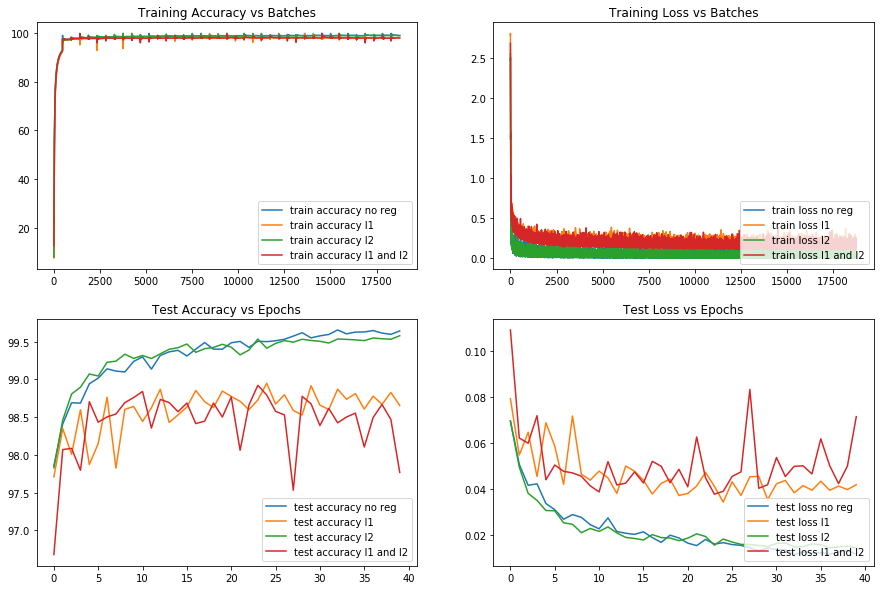

In [78]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_acc_no_reg, label = "train accuracy no reg")
axs[0, 0].plot(train_acc_l1, label = "train accuracy l1")
axs[0, 0].plot(train_acc_l2, label = "train accuracy l2")
axs[0, 0].plot(train_acc_l1_l2, label = "train accuracy l1 and l2")
axs[0, 0].legend(loc="lower right")
axs[0, 0].set_title("Training Accuracy vs Batches")

axs[0, 1].plot(train_losses_no_reg, label = "train loss no reg")
axs[0, 1].plot(train_losses_l1, label = "train loss l1")
axs[0, 1].plot(train_losses_l2, label = "train loss l2")
axs[0, 1].plot(train_losses_l1_l2, label = "train loss l1 and l2")
axs[0, 1].legend(loc="lower right")
axs[0, 1].set_title("Training Loss vs Batches")

axs[1, 0].plot(test_acc_no_reg, label = "test accuracy no reg")
axs[1, 0].plot(test_acc_l1, label = "test accuracy l1")
axs[1, 0].plot(test_acc_l2, label = "test accuracy l2")
axs[1, 0].plot(test_acc_l1_l2, label = "test accuracy l1 and l2")
axs[1, 0].legend(loc="lower right")
axs[1, 0].set_title("Test Accuracy vs Epochs")

axs[1, 1].plot(test_losses_no_reg, label = "test loss no reg")
axs[1, 1].plot(test_losses_l1, label = "test loss l1")
axs[1, 1].plot(test_losses_l2, label = "test loss l2")
axs[1, 1].plot(test_losses_l1_l2, label = "test loss l1 and l2")
axs[1, 1].legend(loc="lower right")
axs[1, 1].set_title("Test Loss vs Epochs")


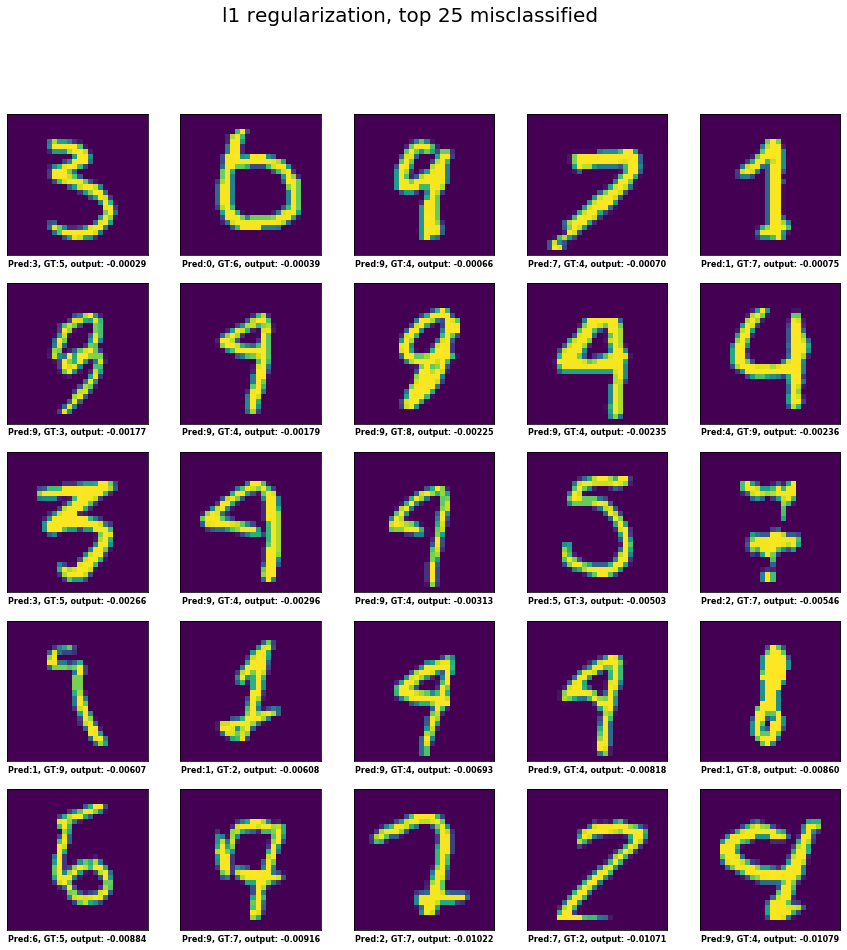

In [72]:
columns = 5
rows = 5 
fig=plt.figure(figsize=(15, 15))
for i in range(1, columns*rows +1):
    img = misclassified_list_l1[i-1][0].cpu().numpy()[0]
    fig.add_subplot(rows, columns, i)
    fig.suptitle("l1 regularization, top 25 misclassified", fontsize=20, horizontalalignment='center')
    xlabel = "Pred:{}, GT:{}, output: {:.5f}".format(misclassified_list_l1[i-1][1], misclassified_list_l1[i-1][3], misclassified_list_l1[i-1][2])
    plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    plt.xlabel(xlabel, fontsize=8, color = 'black', fontweight='bold', horizontalalignment='center')
    plt.imshow(img)

plt.show()

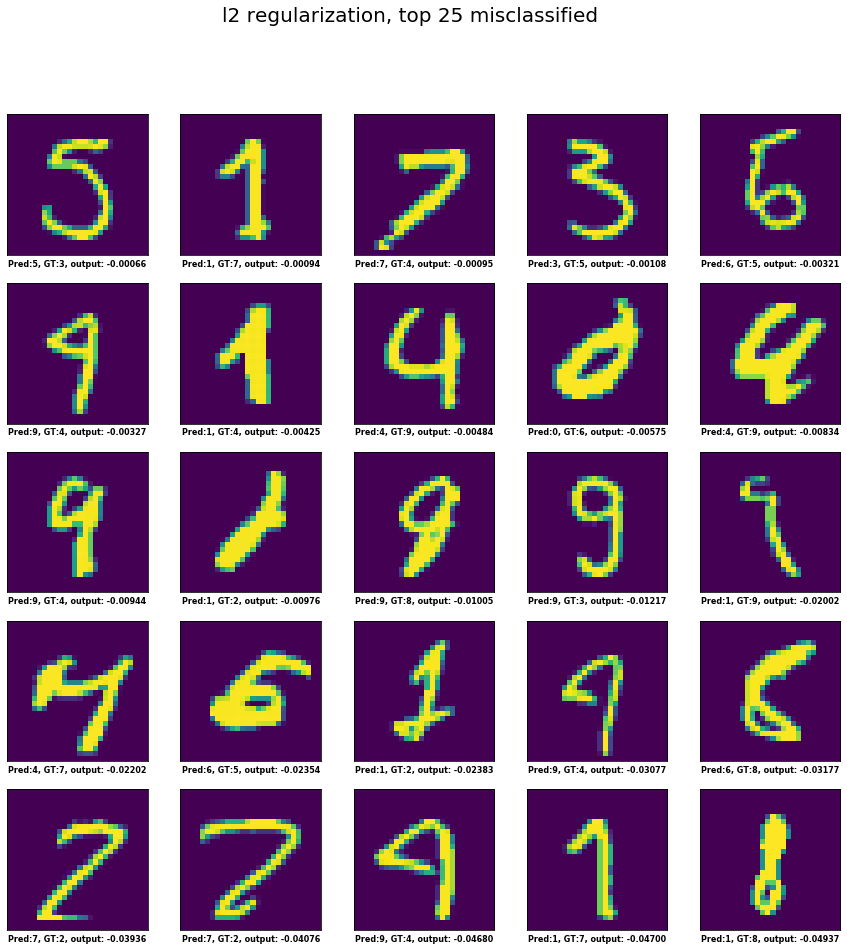

In [79]:
columns = 5
rows = 5 
fig=plt.figure(figsize=(15, 15))
for i in range(1, columns*rows +1):
    img = misclassified_list_l2[i-1][0].cpu().numpy()[0]
    fig.add_subplot(rows, columns, i)
    fig.suptitle("l2 regularization, top 25 misclassified", fontsize=20, horizontalalignment='center')
    xlabel = "Pred:{}, GT:{}, output: {:.5f}".format(misclassified_list_l2[i-1][1], misclassified_list_l2[i-1][3], misclassified_list_l2[i-1][2])
    plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    plt.xlabel(xlabel, fontsize=8, color = 'black', fontweight='bold', horizontalalignment='center')
    plt.imshow(img)

plt.show()

In [75]:
misclassified_list_l2[0]

[tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

In [76]:
misclassified_list_l1[0]

[tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424